# Credit Card Fraud Detection

- Kaggle'daki [Credit Card Fraud Detection Dataset](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data)

- [Credit Card Fraud Detection Hugging Face](https://huggingface.co/spaces/btulftma/credit-card-detection)

- [Credit Card Fraud Detection Github](https://github.com/FBetulS/credit-card/tree/main)

## Giriş
Bu proje, dengesiz bir veri setinde dolandırıcılık tespiti için makine öğrenimi tekniklerini kullanmayı amaçlamaktadır. Veri seti, kredi kartı işlemlerinin özelliklerini içermektedir ve dolandırıcılık işlemlerinin tespiti için çeşitli yöntemler uygulanacaktır.

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    classification_report, 
    f1_score
)

import lightgbm as lgb
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Dropout

## Veri Okuma

In [4]:
# Veriyi yükle
df = pd.read_csv("creditcard.csv")

In [5]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Normal İşlemler: 284315
Dolandırıcılık: 492


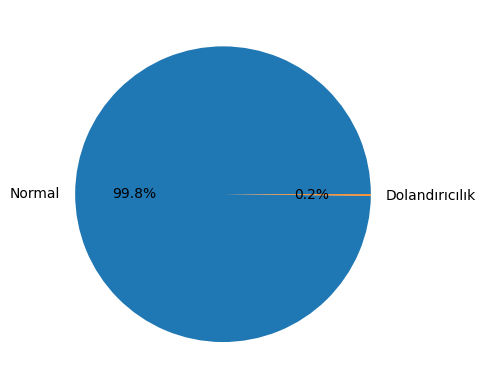

In [6]:
# Sınıf dağılımı
fraud_count = df['Class'].value_counts()
print(f"Normal İşlemler: {fraud_count[0]}\nDolandırıcılık: {fraud_count[1]}")
plt.pie(fraud_count, labels=['Normal', 'Dolandırıcılık'], autopct='%1.1f%%')
plt.show()

## SMOTE Uygulaması
SMOTE (Synthetic Minority Over-sampling Technique), dengesiz veri setlerinde azınlık sınıfın daha iyi temsil edilmesi için yeni örnekler oluşturur. Bu, dolandırıcılık işlemlerinin sayısını artırarak modelin öğrenme yeteneğini geliştirir.

In [8]:
X = df.drop('Class', axis=1)
y = df['Class']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [10]:
# SMOTE uygulama
smote = SMOTE(sampling_strategy=0.5, random_state=42)  # Dolandırıcılık oranını %50'ye çıkar
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

print("Yeni Dağılım:", y_resampled.value_counts())

Yeni Dağılım: Class
0    199008
1     99504
Name: count, dtype: int64


## Model Oluşumu
Autoencoder ve LightGBM modeli kullanılarak dolandırıcılık tespiti yapılacaktır. Öncelikle bir autoencoder modeli oluşturulacak, ardından bu model normal işlemlerle eğitilecektir.

In [12]:
# Encoder
encoder_input = Input(shape=(X_resampled.shape[1],))
x = Dense(16, activation='relu')(encoder_input)
x = Dropout(0.2)(x)
x = Dense(8, activation='relu')(x)
x = Dense(4, activation='relu')(x)  # Latent space
encoder = Model(encoder_input, x)

# Decoder
decoder_input = Input(shape=(4,))  # Latent boyut
x = Dense(8, activation='relu')(decoder_input)
x = Dense(16, activation='relu')(x)
decoder_output = Dense(X_resampled.shape[1], activation='linear')(x)
decoder = Model(decoder_input, decoder_output)

# Autoencoder
autoencoder = Model(encoder.input, decoder(encoder.output))
autoencoder.compile(optimizer='adam', loss='mse')

# Sadece normal işlemlerle eğitim (y_resampled=0 olanlar)
normal_samples = X_resampled[y_resampled == 0]
autoencoder.fit(normal_samples, normal_samples, epochs=20, batch_size=64, validation_split=0.2)

Epoch 1/20
2488/2488 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 47673668.0000 - val_loss: 14026374.0000
Epoch 2/20
2488/2488 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 658629.1875 - val_loss: 14895332.0000
Epoch 3/20
2488/2488 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 435724.4375 - val_loss: 15322760.0000
Epoch 4/20
2488/2488 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 222006.3906 - val_loss: 15157837.0000
Epoch 5/20
2488/2488 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 118613.3906 - val_loss: 15013892.0000
Epoch 6/20
2488/2488 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 103515.8984 - val_loss: 15402361.0000
Epoch 7/20
2488/2488 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 68226.7969 - val_loss: 15869185.0000
Epoch 8/20
2488/2488 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 46889.1367 - val_loss: 15524511.0000
Epoch 9/20
2488/2488 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 43656.5859 - val_loss: 14810099.0000
Epoch 10/20
2488/2488 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 32085.7891 - val_loss: 15292032.0000
E

## LightGBM Modeli

In [14]:
# LightGBM modeli
model = lgb.LGBMClassifier(
    objective='binary',
    num_leaves=32,
    max_depth=6,
    learning_rate=0.05,
    n_estimators=200,
    is_unbalance=True
)

# Eğitim
model.fit(X_resampled, y_resampled)

[LightGBM] [Info] Number of positive: 99504, number of negative: 199008
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 298512, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147


LGBMClassifier(is_unbalance=True, learning_rate=0.05, max_depth=6,
               n_estimators=200, num_leaves=32, objective='binary')

In [15]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print("F1-Score:", f1_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.52      0.89      0.66       136

    accuracy                           1.00     85443
   macro avg       0.76      0.94      0.83     85443
weighted avg       1.00      1.00      1.00     85443

F1-Score: 0.659400544959128


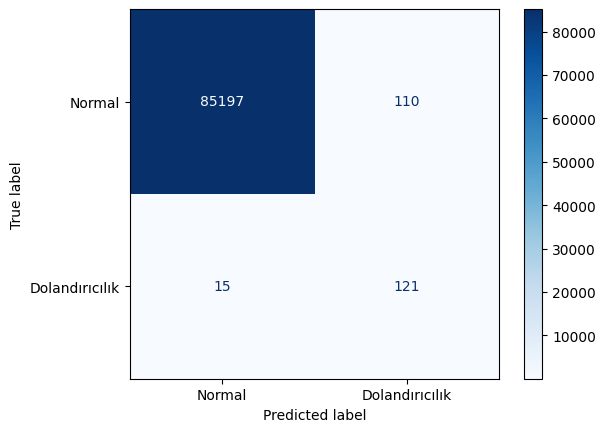

In [17]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['Normal', 'Dolandırıcılık'])
disp.plot(cmap='Blues')
plt.show()

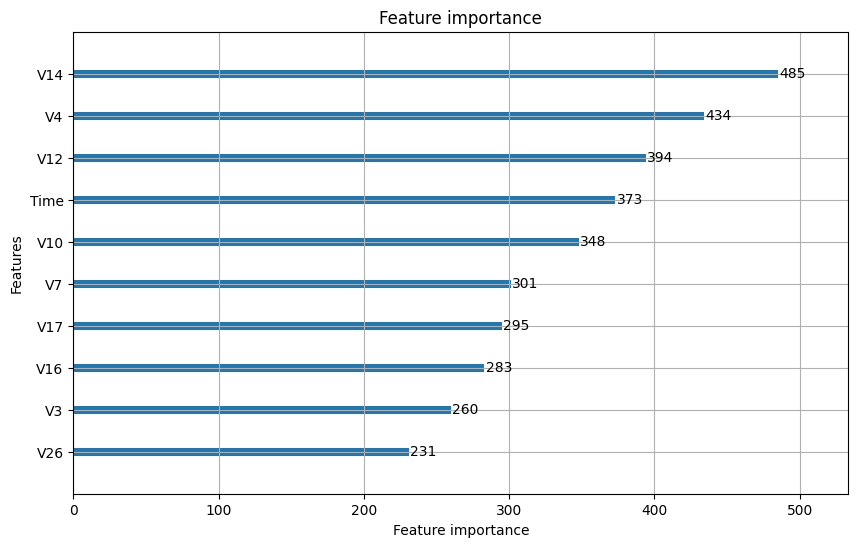

In [18]:
# Feature Importance
lgb.plot_importance(model, figsize=(10, 6), max_num_features=10)
plt.show()

## Hiperparametre Optimizasyonu
GridSearchCV kullanılarak modelin en iyi hiperparametreleri belirlenecektir.

In [20]:
# Parametre grid'i
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [24, 32, 48],
    'max_depth': [4, 6, 8],
    'min_child_samples': [50, 100]
}

# Model
model = lgb.LGBMClassifier(objective='binary', n_estimators=200, is_unbalance=True)

# Grid Search
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=2)
grid_search.fit(X_resampled, y_resampled)

# En iyi parametreler
print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[LightGBM] [Info] Number of positive: 99504, number of negative: 199008
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028808 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 298512, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
Best Parameters: {'learning_rate': 0.1, 'max_depth': 8, 'min_child_samples': 50, 'num_leaves': 48}


In [47]:
# GridSearchCV'den gelen en iyi parametreler
best_params = {
    'learning_rate': 0.1,
    'max_depth': 8,
    'min_child_samples': 50,
    'num_leaves': 48,
    'objective': 'binary',
    'is_unbalance': True  # Dengesiz veri için
}

# Final modeli
final_model = lgb.LGBMClassifier(**best_params, n_estimators=500)
final_model.fit(X_resampled, y_resampled)

[LightGBM] [Info] Number of positive: 99504, number of negative: 199008
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 298512, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

LGBMClassifier(is_unbalance=True, max_depth=8, min_child_samples=50,
               n_estimators=500, num_leaves=48, objective='binary')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.87      0.87      0.87       136

    accuracy                           1.00     85443
   macro avg       0.94      0.93      0.94     85443
weighted avg       1.00      1.00      1.00     85443



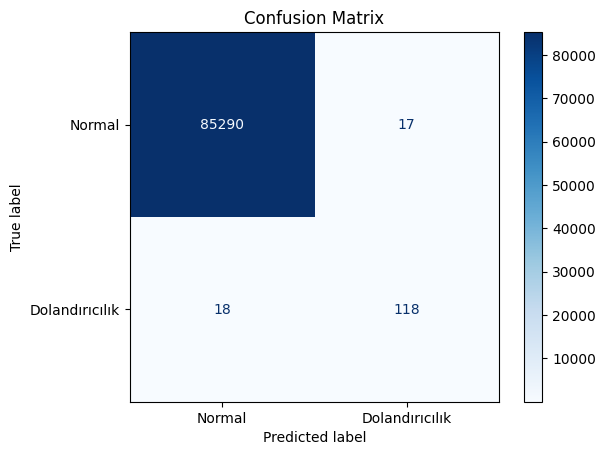

In [57]:
# Tahminler
y_pred = final_model.predict(X_test)
y_proba = final_model.predict_proba(X_test)[:, 1]

# Detaylı rapor
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['Normal', 'Dolandırıcılık'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [66]:
import joblib
from tensorflow.keras.models import save_model

# LightGBM modelini kaydet
joblib.dump(final_model, 'fraud_detection_lgbm.pkl')

# Autoencoder'ı kaydet (MSE özelliği için)
save_model(autoencoder, 'autoencoder_model.h5')

# Özellik mühendisliği fonksiyonlarını kaydet (opsiyonel)
with open('preprocessing_functions.pkl', 'wb') as f:
    joblib.dump({
        'smote': smote,
        'feature_engineering': True
    }, f)

In [68]:
# Encoder'ı input_shape ile yeniden tanımla
encoder_input = Input(shape=(X_resampled.shape[1],), name='input_layer')  # batch_shape yerine shape kullan
x = Dense(16, activation='relu')(encoder_input)
x = Dropout(0.2)(x)
x = Dense(8, activation='relu')(x)
x = Dense(4, activation='relu')(x)
encoder = Model(encoder_input, x)

# Decoder ve Autoencoder aynı
# ...

# Modeli yeniden kaydet
autoencoder.save('autoencoder_model.h5', save_format='h5')

# Proje Sonuçları

## Genel Sonuçlar
Bu proje, kredi kartı işlemlerinde dolandırıcılık tespitini hedeflemiştir. Veri seti dengesiz olup, dolandırıcılık işlemleri az sayıda bulunmaktadır.

### İlk Model Sonuçları
- **F1-Skoru**: 0.659
- **Doğruluk**: %100
- **Precision**: 0.52
- **Recall**: 0.89

İlk model, dolandırıcılık tespitinde sınırlı bir performans göstermiştir.

## Hiperparametre Optimizasyonu
GridSearchCV ile en iyi parametreler belirlendi:
- **Learning Rate**: 0.1
- **Max Depth**: 8
- **Min Child Samples**: 50
- **Num Leaves**: 48

### İyileştirilmiş Model Sonuçları
- **F1-Skoru**: 0.87
- **Doğruluk**: %100
- **Precision**: 0.87
- **Recall**: 0.87

## Karşılaştırma
| Model             | F1-Skoru | Precision | Recall |
|-------------------|-----------|-----------|--------|
| İlk Model         | 0.659     | 0.52      | 0.89   |
| İyileştirilmiş Model | 0.87      | 0.87      | 0.87   |

## Sonuç
Hiperparametre optimizasyonu, modelin dolandırıcılık tespitindeki doğruluğunu artırmıştır. Gelecek çalışmalar için daha fazla veri ve farklı tekniklerin kullanılması önerilmektedir.